<a href="https://colab.research.google.com/github/dcolinmorgan/prediction/blob/master/PANDA_null.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Skip to relevant sections:
* [__negative control function__](#negative-control)
   * [LTCOPD negCont](#LTCOPD_netCont)
   * [load diff net data](#load-diff-net-data)
   * [plot diff degree distributions](#plot-diff-degree-distribution)

In [ ]:
# !pip install s3fs
import os
# import s3fs
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
import gc
import random
from scipy import stats
import seaborn as sns
from IPython.display import Image
from scipy.stats import zscore
import time


timestr = time.strftime("%Y%m%d-%H%M")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/netZoo/netZooPy.git
!git clone --single-branch --branch devel https://github.com/netZoo/netZooPy.git
os.chdir('netZooPy')
!pip install -e ./

In [ ]:
import netZooPy
from netZooPy.panda import Panda
from netZooPy.lioness import Lioness
from netZooPy import condor
# os.chdir('..')

In [ ]:
!pip install GEOparse

In [ ]:
import GEOparse
gse = GEOparse.get_GEO(geo="GSE76925", destdir="./")

20-May-2021 17:37:34 DEBUG utils - Directory ./ already exists. Skipping.
20-May-2021 17:37:34 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE76nnn/GSE76925/soft/GSE76925_family.soft.gz to ./GSE76925_family.soft.gz
100%|██████████| 70.3M/70.3M [00:02<00:00, 32.7MB/s]
20-May-2021 17:37:37 DEBUG downloader - Size validation passed
20-May-2021 17:37:37 DEBUG downloader - Moving /tmp/tmpmhor42zg to /content/GSE76925_family.soft.gz
20-May-2021 17:37:37 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE76nnn/GSE76925/soft/GSE76925_family.soft.gz
20-May-2021 17:37:37 INFO GEOparse - Parsing ./GSE76925_family.soft.gz: 
20-May-2021 17:37:37 DEBUG GEOparse - DATABASE: GeoMiame
20-May-2021 17:37:37 DEBUG GEOparse - SERIES: GSE76925
20-May-2021 17:37:37 DEBUG GEOparse - PLATFORM: GPL10558
20-May-2021 17:37:38 DEBUG GEOparse - SAMPLE: GSM2040792
20-May-2021 17:37:39 DEBUG GEOparse - SAMPLE: GSM2040793
20-May-2021 17:37:39 DEBUG GEOparse - SAMP

In [ ]:
expression1 = gse.pivot_samples('VALUE')
gpl = gse.gpls[next(iter(gse.gpls))]
data = gse.pivot_samples(values="VALUE")#, gpl=gpl, annotation_column="Symbol")
pheno=gse.phenotype_data.rename(columns={'characteristics_ch1.0.age': 'age',"characteristics_ch1.1.Sex":"sex","characteristics_ch1.3.bmi":"bmi","characteristics_ch1.6.fev1.pp":"fev1","characteristics_ch1.4.packyears":"PY"})
pheno[['age',"sex","bmi","fev1","PY"]].to_csv('pheno_data.txt',sep='\t',index=True,header=True)

names=pd.DataFrame([gse.gpls['GPL10558'].table['ID'],gse.gpls['GPL10558'].table['ILMN_Gene']]).transpose()
data1=pd.merge(expression1,names,left_index=True,right_on='ID')

data1['loc']=gse.gpls['GPL10558'].table['Chromosome']

data1.index=data1['ILMN_Gene']
data1=data1.dropna(how='any')
del data1['ID'], data1['ILMN_Gene']
motif_data='coding_LCL_motif.txt'
ppi_data='ppi_complete.txt'
del gpl, expression1
# data1.to_csv('drive/My Drive/Colab Notebooks/GSE76925.txt',sep='\t')

#create and run PANDA

In [ ]:
data3=data1.copy()
data3=data3[(data3['loc']!='XY')&(data3['loc']!='Y')]
del data3['loc']
data3.columns=[gse.phenotype_data['characteristics_ch1.1.Sex']+gse.phenotype_data['characteristics_ch1.5.copd']]
data3.loc[:,'Fcase'].to_csv('Fcase.txt',sep='\t',index=True,header=False)
data3.loc[:,'Fcont'].to_csv('Fcont.txt',sep='\t',index=True,header=False)
# [data3.loc[:,'Fcase'].shape,data3.loc[:,'Fcont'].shape]
print([data3.loc[:,'Fcase'].shape,data3.loc[:,'Fcont'].shape])

data4=data1.copy() #data4[data4['loc']!='Y']
del data4['loc']
data4.columns=[gse.phenotype_data['characteristics_ch1.1.Sex']+gse.phenotype_data['characteristics_ch1.5.copd']]
data4.loc[:,'Mcase'].to_csv('Mcase.txt',sep='\t',index=True,header=False)
data4.loc[:,'Mcont'].to_csv('Mcont.txt',sep='\t',index=True,header=False)
print([data4.loc[:,'Mcase'].shape,data4.loc[:,'Mcont'].shape])

[(28635, 59), (28635, 25)]
[(28725, 52), (28725, 15)]


In [ ]:
LCL_ppi=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/ppi/ppi_complete.txt',sep='\t',header=None)
LCL_ppi.to_csv('ppi_complete.txt',sep='\t',index=False,header=False)

coding_LCL_motif=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/motifs/Hugo_motifCellLine.txt',sep='\t',header=None)
coding_LCL_motif.to_csv('coding_LCL_motif.txt',sep='\t',index=False,header=False)

motif_data='coding_LCL_motif.txt'
ppi_data='ppi_complete.txt'

In [ ]:
panda_obj1 = Panda('Fcase.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=True, keep_expression_matrix = False,modeProcess = 'intersection')
np.save('Panda_Fcase.npy',panda_obj1.export_panda_results) #save_memory=True,save_tmp=False,precision='single',keep_expression_matrix=False
del panda_obj1
panda_obj2 = Panda('Mcase.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=True, keep_expression_matrix = False,modeProcess = 'intersection')
np.save('Panda_Mcase.npy',panda_obj2.export_panda_results)
del panda_obj2
panda_obj3 = Panda('Fcont.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=True, keep_expression_matrix = False,modeProcess = 'intersection')
np.save('Panda_Fcont.npy',panda_obj3.export_panda_results)
del panda_obj3
panda_obj4 = Panda('Mcont.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=True, keep_expression_matrix = False,modeProcess = 'intersection')
np.save('Panda_Mcont.npy',panda_obj4.export_panda_results)
del panda_obj4
# panda_obj5 = Panda('FcaseFULL.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=False, keep_expression_matrix = True,modeProcess = 'intersection')
# np.save('drive/My Drive/Panda_FcaseFULL.npy',panda_obj5.export_panda_results)
# del panda_obj5
# panda_obj6 = Panda('FcontFULL.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=False, keep_expression_matrix = True,modeProcess = 'intersection')
# np.save('drive/My Drive/Panda_FcontFULL.npy',panda_obj6.export_panda_results)
# del panda_obj6


##Load Panda nets

In [ ]:
Panda_Mcase=np.load('Panda_Mcase.npy',allow_pickle=True)
Panda_Mcont=np.load('Panda_Mcont.npy',allow_pickle=True)
Panda_Mcont=pd.DataFrame(Panda_Mcont)
Panda_Mcont.columns=['tf','gene','motif','force']
Panda_Mcase=pd.DataFrame(Panda_Mcase)
Panda_Mcase.columns=['tf','gene','motif','force']

Panda_Fcase=np.load('Panda_Fcase.npy',allow_pickle=True)
Panda_Fcont=np.load('Panda_Fcont.npy',allow_pickle=True)
Panda_Fcont=pd.DataFrame(Panda_Fcont)
Panda_Fcont.columns=['tf','gene','motif','force']
Panda_Fcase=pd.DataFrame(Panda_Fcase)
Panda_Fcase.columns=['tf','gene','motif','force']


##TF and gene specific zscore diff F



In [ ]:
from scipy.stats import zscore
# Panda_nullA.panda_results = pd.DataFrame(Panda_nullA.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results3 = Panda_Fcont.sort_values(by=['force'], ascending=False)
# subset_panda_results3['merge']=subset_panda_results3.tf+'-'+subset_panda_results3.gene

# Panda_nullB.panda_results = pd.DataFrame(Panda_nullB.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results1 = Panda_Fcase.sort_values(by=['force'], ascending=False)
# subset_panda_results1['merge']=subset_panda_results1.tf+'-'+subset_panda_results1.gene
del subset_panda_results3['motif'],subset_panda_results1['motif']
TFsum_3=subset_panda_results3.groupby(['tf']).agg({'force':sum})
TFsum_1=subset_panda_results1.groupby(['tf']).agg({'force':sum})
TFsum_1['force']=zscore(TFsum_1['force'])
TFsum_3['force']=zscore(TFsum_3['force']) ##reduces range from 1500 to 3

geneSum_3=subset_panda_results3.groupby(['gene']).agg({'force':sum})
geneSum_1=subset_panda_results1.groupby(['gene']).agg({'force':sum})
geneSum_3['force']=zscore(geneSum_3['force'])
geneSum_1['force']=zscore(geneSum_1['force'])

mmm=TFsum_3.merge(TFsum_1, left_on=['tf'], right_on=['tf'])
mmmm=geneSum_3.merge(geneSum_1, left_on=['gene'], right_on=['gene'])

del [[subset_panda_results3, subset_panda_results1,Panda_Fcont,Panda_Fcase]]
gc.collect()
subset_panda_results3=pd.DataFrame()
subset_panda_results1=pd.DataFrame()
Panda_Fcont=pd.DataFrame()
Panda_Fcont=pd.DataFrame()


mmm['diff']=mmm.force_x-mmm.force_y
mmm = mmm.sort_values(by ='diff' )


mmmm['diff']=mmmm.force_x-mmmm.force_y
mmmm = mmmm.sort_values(by ='diff' )
mmm.to_csv('TF_zscore_F.txt',sep='\t')
mmmm.to_csv('gene_zscore_F.txt',sep='\t')

Text(0.5, 1.0, 'female zscored sum TF diff')

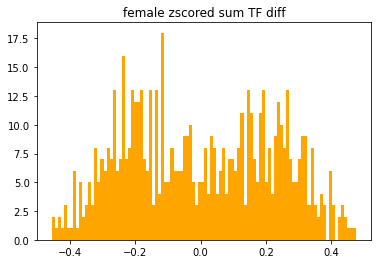

In [ ]:
plt.hist(mmm['diff'],bins=100,color='orange')
plt.title('female zscored sum TF diff')

Text(0.5, 1.0, 'female zscored sum gene diff')

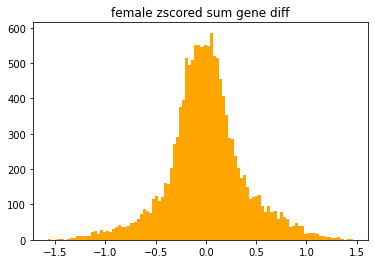

In [ ]:
plt.hist(mmmm['diff'],bins=100,color='orange')
plt.title('female zscored sum gene diff')

##TF and gene specific zscore diff M

In [ ]:

# Panda_nullA.panda_results = pd.DataFrame(Panda_nullA.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results3 = Panda_Mcont.sort_values(by=['force'], ascending=False)
# subset_panda_results3['merge']=subset_panda_results3.tf+'-'+subset_panda_results3.gene

# Panda_nullB.panda_results = pd.DataFrame(Panda_nullB.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results1 = Panda_Mcase.sort_values(by=['force'], ascending=False)
# subset_panda_results1['merge']=subset_panda_results1.tf+'-'+subset_panda_results1.gene
del subset_panda_results3['motif'],subset_panda_results1['motif']
TFsum_3=subset_panda_results3.groupby(['tf']).agg({'force':sum})
TFsum_1=subset_panda_results1.groupby(['tf']).agg({'force':sum})
TFsum_1['force']=zscore(TFsum_1['force'])
TFsum_3['force']=zscore(TFsum_3['force'])

geneSum_3=subset_panda_results3.groupby(['gene']).agg({'force':sum})
geneSum_1=subset_panda_results1.groupby(['gene']).agg({'force':sum})
geneSum_3['force']=zscore(geneSum_3['force'])
geneSum_1['force']=zscore(geneSum_1['force'])

nnn=TFsum_3.merge(TFsum_1, left_on=['tf'], right_on=['tf'])
nnnn=geneSum_3.merge(geneSum_1, left_on=['gene'], right_on=['gene'])

del [[subset_panda_results3, subset_panda_results1,Panda_Mcont,Panda_Mcase]]
gc.collect()
subset_panda_results3=pd.DataFrame()
subset_panda_results1=pd.DataFrame()
Panda_Mcont=pd.DataFrame()
Panda_Mcase=pd.DataFrame()


nnn['diff']=nnn.force_x-nnn.force_y
nnn = nnn.sort_values(by ='diff' )


nnnn['diff']=nnnn.force_x-nnnn.force_y
nnnn = nnnn.sort_values(by ='diff' )
nnn.to_csv('TF_zscore_M.txt',sep='\t')
nnnn.to_csv('gene_zscore_M.txt',sep='\t')


Text(0.5, 1.0, 'male zscored sum TF diff')

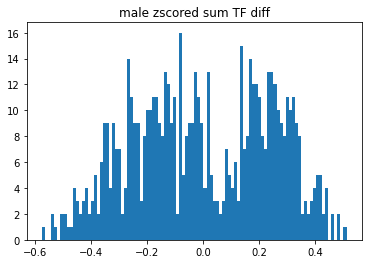

In [ ]:
plt.hist(nnn['diff'],bins=100)
plt.title('male zscored sum TF diff')

Text(0.5, 1.0, 'male zscored sum gene diff')

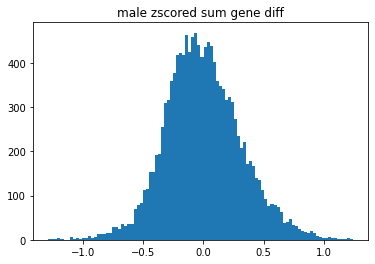

In [ ]:
plt.hist(nnnn['diff'],bins=100)
plt.title('male zscored sum gene diff')

In [ ]:
ff=pd.read_csv('TF_zscore_F.txt',sep='\t',header=0)
fff=pd.read_csv('gene_zscore_F.txt',sep='\t',header=0)
mm=pd.read_csv('TF_zscore_M.txt',sep='\t',header=0)
mmm=pd.read_csv('gene_zscore_M.txt',sep='\t',header=0)
sex_tf_diff=ff.merge(mm,on='tf')
sex_gene_diff=fff.merge(mmm,on='gene')
 
# plt.figure(figsize=(15,6))
# sex_tf_diff['sexdiff']=sex_tf_diff['diff_x']-sex_tf_diff['diff_y']
# # sex_tf_diff=sex_tf_diff.sort_values(by=['sexdiff'])
# sex_tf_diff=sex_tf_diff.sort_values(by=['tf'])
# sns.barplot(data=sex_tf_diff,y='sexdiff',x='tf')

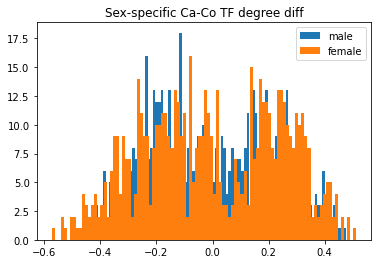

In [ ]:
a=plt.hist(sex_tf_diff['diff_x'],bins=100,label='male')
b=plt.hist(sex_tf_diff['diff_y'],bins=100,label='female')
plt.title('Sex-specific Ca-Co TF degree diff')
plt.legend(loc="best")

In [ ]:
[sex_tf_diff[(sex_tf_diff['diff_y'])>.4].tf.values,sex_tf_diff[(sex_tf_diff['diff_y'])<-0.5].tf.values] #,sex_tf_diff[np.abs(sex_tf_diff['diff_y'])>.4].tf]

[array(['HOXD9', 'MEF2A', 'POU3F1', 'POU1F1', 'POU4F1', 'POU4F3', 'LHX3',
        'NKX6-1', 'LIN54', 'DMRTC2', 'DMRT2', 'ZNF32', 'GATA5', 'HMG20B',
        'MSX2', 'MSX1', 'POU3F3', 'POU3F2', 'LHX1', 'FOXB1', 'FOXD2',
        'BARX1', 'TBPL2'], dtype=object),
 array(['KLF5', 'PURA', 'ZNF281', 'KLF1', 'KLF15', 'KLF4'], dtype=object)]

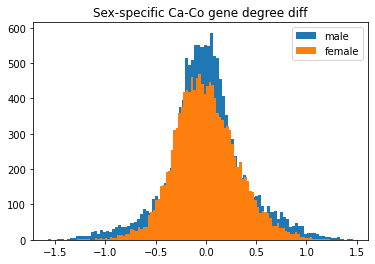

In [ ]:
a=plt.hist(sex_gene_diff['diff_x'],bins=100,label='male')
b=plt.hist(sex_gene_diff['diff_y'],bins=100,label='female')
plt.title('Sex-specific Ca-Co gene degree diff')
plt.legend(loc="best")

In [ ]:
[sex_gene_diff[(sex_gene_diff['diff_y'])>.4].gene.values,sex_gene_diff[(sex_gene_diff['diff_y'])<-1].gene.values] #,sex_tf_diff[np.abs(sex_tf_diff['diff_y'])>.4].tf]

[array(['SLC45A2', 'WFDC3', 'EFR3B', ..., 'LTK', 'PAX8', 'AIFM2'],
       dtype=object),
 array(['AHSA2', 'PLXNA4', 'NANP', 'SNX3', 'DNAJC5B', 'ACO2', 'ADAMDEC1',
        'BTAF1', 'SLC7A6', 'GOLGA6B', 'SNORD10', 'WDR31', 'ETFDH', 'SFXN3',
        'CCR4', 'TSTD2', 'CD4', 'UBE2V1', 'SH2B3', 'BCL2L15'], dtype=object)]

#negative control
create 4 randomly chosen subsets to test difference of differences between panda nets

use other colab for more memory:
https://colab.research.google.com/drive/1ebLeRX6Gwywgs1Yn_gcL8TYufgkfbchX#scrollTo=wS_rwFkacl74






In [ ]:
design=[gse.phenotype_data['characteristics_ch1.1.Sex']+gse.phenotype_data['characteristics_ch1.5.copd']]
design=pd.DataFrame(design).T
design.columns=['group']
jeff=design.pivot_table(index=['group'], aggfunc='size')
print(jeff[0],jeff[1],jeff[2],jeff[3])

timestr = time.strftime("%Y%m%d")
# design=pd.read_csv(design_file,sep='\t',index_col=None)
MC=jeff[0]#np.sum(design)
MNC=jeff[1]#design.shape[1]-MC
inits=100

del data1['loc']
j=np.random.choice(data1.shape[1], size=(MC+MNC, ),replace=False) ## total males
nullA=data1.iloc[:,j.tolist()] ##reduce to random set
# null2=data.drop(nullA.columns,axis=1) ## create second group without these

k=np.random.choice(j,MNC,replace=False) ## male controls
nullB=data1.iloc[:,k.tolist()] ##remove controls from male pop
nullA=nullA.drop(nullB.columns,axis=1) ## remove these from male cases



59 25 52 15


In [ ]:
def negCont(nullA,nullB,i,timestr,motif_data,ppi_data):
  panda_nullA = Panda(nullA, motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = True, remove_missing=True, keep_expression_matrix = False,modeProcess = 'intersection')
  # np.save('drive/My Drive/Panda_nullA.npy',panda_nullA.export_panda_results)
  panda_nullB = Panda(nullB, motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = True, remove_missing=True, keep_expression_matrix = False,modeProcess = 'intersection')
  # np.save('drive/My Drive/Panda_nullB.npy',panda_nullB.export_panda_results)
  uniq_tfs=np.intersect1d(panda_nullA.ppi_tfs,panda_nullA.motif_tfs)
  uniq_genes=np.intersect1d(panda_nullA.motif_genes,panda_nullA.expression_genes)
  tfs = np.tile(uniq_tfs, (len(uniq_genes), 1)).flatten()
  genes = np.repeat(uniq_genes,panda_nullA.num_tfs)
  forceA = panda_nullA.motif_matrix.flatten(order='F')
  forceB = panda_nullB.motif_matrix.flatten(order='F')
  export_panda_results = pd.DataFrame({'tf':tfs, 'gene': genes,'forceA': forceA,'forceB': forceB})#.sort_values(by=['force'], ascending=False)

  # subset_panda_resultsA = panda_nullA.export_panda_results.sort_values(by=['force'], ascending=False)
  # subset_panda_resultsB = panda_nullB.export_panda_results.sort_values(by=['force'], ascending=False)
  # del subset_panda_resultsA['motif'],subset_panda_resultsB['motif']
  # del panda_nullA, panda_nullB, forceA, forceB, tfs, genes

  ##aggregate TF link sum and zscore
  TFsum_A=export_panda_results.groupby(['tf']).agg({'forceA':sum})
  TFsum_B=export_panda_results.groupby(['tf']).agg({'forceB':sum})
  TFsum_B['force']=zscore(TFsum_B['forceB'])
  TFsum_A['force']=zscore(TFsum_A['forceA'])

  ##aggregate gene link sum and zscore
  geneSum_A=export_panda_results.groupby(['gene']).agg({'forceA':sum})
  geneSum_B=export_panda_results.groupby(['gene']).agg({'forceB':sum})
  geneSum_A['force']=zscore(geneSum_A['forceA'])
  geneSum_B['force']=zscore(geneSum_B['forceB'])

  ##merge
  sumTFdiff=TFsum_A.merge(TFsum_B, left_on=['tf'], right_on=['tf'])
  sumGenediff=geneSum_A.merge(geneSum_B, left_on=['gene'], right_on=['gene'])

  del export_panda_results #[[subset_panda_resultsA, subset_panda_resultsB]]
  gc.collect()
  export_panda_results=pd.DataFrame()
  # subset_panda_resultsA=pd.DataFrame()
  # subset_panda_resultsB=pd.DataFrame()

  ##diff
  sumTFdiff['diff']=sumTFdiff.force_x-sumTFdiff.force_y
  # sumTFdiff = sumTFdiff.sort_values(by ='diff' )
  del sumTFdiff['force_x'], sumTFdiff['force_y']
  sumTFdiff=sumTFdiff.sort_index(axis=0)
  sumTFdiff=sumTFdiff.T
  sumGenediff['diff']=sumGenediff.force_x-sumGenediff.force_y
  # sumGenediff = sumGenediff.sort_values(by ='diff' )
  del sumGenediff['force_x'], sumGenediff['force_y']
  sumGenediff=sumGenediff.sort_index(axis=0)
  sumGenediff=sumGenediff.T
  if i==1:
    sumTFdiff.to_csv('drive/MyDrive/harvard/null_panda/TF_zscore_rand_'+timestr+'.txt',sep='\t',header=True,index=None)
    sumGenediff.to_csv('drive/MyDrive/harvard/null_panda/gene_zscore_rand_'+timestr+'.txt',sep='\t',header=True,index=None)
  elif i!=1:
    sumTFdiff.to_csv('drive/MyDrive/harvard/null_panda/TF_zscore_rand_'+timestr+'.txt',sep='\t',header=None,index=None,mode='a')
    sumGenediff.to_csv('drive/MyDrive/harvard/null_panda/gene_zscore_rand_'+timestr+'.txt',sep='\t',header=None,index=None,mode='a')
  del sumTFdiff, sumGenediff
  gc.collect()

In [ ]:
# del data1['loc']
for i in range(1,inits):
    ## form two random groups of exact size as initial cases and controls
    # data=pd.read_csv(expression_file,sep='\t',index_col=0)
    j=np.random.choice(data1.shape[1], size=(MC+MNC, ),replace=False) ## total males
    nullA=data1.iloc[:,j.tolist()] ##reduce to random set
    # null2=data.drop(nullA.columns,axis=1) ## create second group without these

    k=np.random.choice(j,MNC,replace=False) ## male controls
    nullB=data1.iloc[:,k.tolist()] ##remove controls from male pop
    nullA=nullA.drop(nullB.columns,axis=1) ## remove these from male cases

    # l=np.random.choice(null2.shape[1], size=(FC.shape[1]+FNC.shape[1], ),replace=False) ##84 total females
    # nullC=null2.iloc[:,l.tolist()] ##subset leftover from first null to 85
    # m=np.random.choice(l[l<FC.shape[1]+1+FNC.shape[1]],FNC.shape[1],replace=False) ##25 controls
    # nullD=nullC.iloc[:,m.tolist()] ##take 25 for female random control
    # nullC=nullC.drop(nullD.columns,axis=1)

    # sumTFdiff,sumGenediff=
    negCont(nullA,nullB,i,timestr,motif_data,ppi_data)

    print('saved iteration='+str(i))

###load diff net data

In [ ]:
TF_diffNull=pd.read_csv('drive/My Drive/harvard/null_panda/TF_zscore_rand_.txt',sep='\t',header=0)
gene_diffNull=pd.read_csv('drive/My Drive/harvard/null_panda/model_output/gene_zscore_rand_.txt',sep='\t',header=0)
TF_diffNull=TF_diffNull.T
gene_diffNull=gene_diffNull.T
gene_diffNull.shape

# TF_diffNull=pd.read_csv('drive/My Drive/TF_zscore_rand_camb.txt',sep='\t',header=0)
# gene_diffNull=pd.read_csv('drive/My Drive/gene_zscore_rand_camb.txt',sep='\t',header=0)
# TF_diffNull=TF_diffNull.T
# gene_diffNull=gene_diffNull.T
# gene_diffNull.shape

(14361, 291)

In [ ]:
male=pd.DataFrame()
for i in range(0,200,2):
  xx=pd.DataFrame([TF_diffNull[TF_diffNull[i]>.5].index,TF_diffNull[TF_diffNull[i]<-.5].index])
  if not xx.empty:
    print(xx)
    male=np.append(male,xx)

In [ ]:
male

In [ ]:
for i in range(1,201,2):
  xx=pd.DataFrame([TF_diffNull[TF_diffNull[i]>.5][0],TF_diffNull[TF_diffNull[i]<-.5][0]])
  if not xx.empty:
    print(i)

103
179
185


In [ ]:
TF_diffNull

In [ ]:
[sex_tf_diff[(sex_tf_diff['diff_y'])>.4].tf.values,sex_tf_diff[(sex_tf_diff['diff_y'])<-0.4].tf.values] #,sex_tf_diff[np.abs(sex_tf_diff['diff_y'])>.4].tf]

###plot diff degree distribution

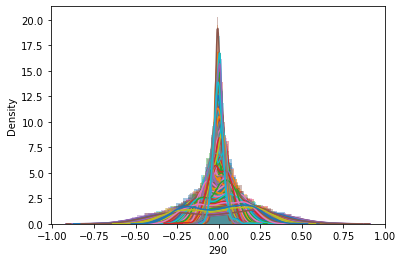

In [ ]:
for i, col in enumerate(TF_diffNull.columns):
    # plt.figure(i)
    tmp=sns.distplot(TF_diffNull[col])

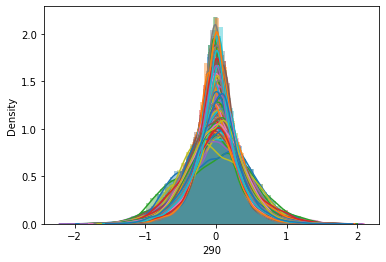

In [ ]:
for i, col in enumerate(gene_diffNull.columns):
    # plt.figure(i)
    tmp=sns.distplot(gene_diffNull[col])

In [ ]:
hist=np.histogram(np.array(TF_diffNull).flatten())#,log=False)
stats.rv_histogram(hist)

In [ ]:
plt.hist(TF_diffNull.unstack(),log=True)

In [ ]:
plt.hist(TF_diffNull.unstack())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


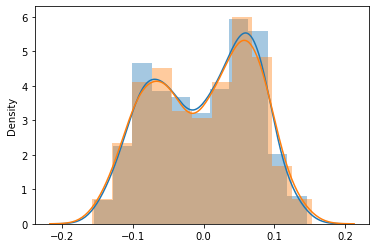

In [ ]:
sns.distplot(np.median(TF_diffNull,axis=1))
sns.distplot(np.mean(TF_diffNull,axis=1))

In [ ]:
hist=np.histogram(np.array(TF_diffNull).flatten(),100)#,log=False)
TF_dNull=stats.rv_histogram(hist)
sampled_list = random.sample(set(mmm['diff']), 100)
stat2, pvalue2 = stats.kstest(sampled_list, cdf=TF_dNull.cdf)#,args=(weight1, mean1, stdv1, mean2, stdv2))
pvalue2

In [ ]:
TFpvalue=pd.DataFrame()
for i, col in enumerate(TF_diffNull.columns):
  hist=np.histogram(np.array(TF_diffNull[col]))#.flatten())#,log=False)
  TF_dNull=stats.rv_histogram(hist)
  sampled_list = random.sample(set(mmm['diff']), 100)
  stat2, pvalue2 = stats.kstest(sampled_list, cdf=TF_dNull.cdf)#,args=(weight1, mean1, stdv1, mean2, stdv2))
  TFpvalue[i+1]=[pvalue2] #np.concatenate([pvalue,pvalue2],axis=0)
TFpvalue=TFpvalue.T
print(TFpvalue)

In [ ]:
TFpvalue[TFpvalue<.005].dropna()

""


In [ ]:
Gpvalue=pd.DataFrame()
for i, col in enumerate(gene_diffNull.columns):
  hist=np.histogram(np.array(gene_diffNull[col]))#.flatten())#,log=False)
  gene_dNull=stats.rv_histogram(hist)
  sampled_list = random.sample(set(mmmm['diff']), 100)
  stat2, pvalue2 = stats.kstest(sampled_list, cdf=gene_dNull.cdf)#,args=(weight1, mean1, stdv1, mean2, stdv2))
  Gpvalue[i+1]=[pvalue2] #np.concatenate([pvalue,pvalue2],axis=0)
Gpvalue=Gpvalue.T
print(Gpvalue)

In [ ]:
Gpvalue[Gpvalue<.005].dropna()

#Age case v control (65yo)

In [ ]:
# del data1['loc']
# Age=(gse.phenotype_data['characteristics_ch1.0.age'].values).astype('float')>64
# len(Age.astype('str'))
# data1=pd.read_csv('drive/My Drive/Colab Notebooks/GSE76925.txt',sep='\t',index_col=0)
# data1
# data1.columns=[Age.astype('str')+gse.phenotype_data['characteristics_ch1.5.copd'].values]

# data1.loc[:,'Truecase'].to_csv('OldCase.txt',sep='\t',index=True,header=False)
# data1.loc[:,'Truecont'].to_csv('OldCont.txt',sep='\t',index=True,header=False)
[data1.loc[:,'Truecase'].shape,#.to_csv('OldCase.txt',sep='\t',index=True,header=False)
data1.loc[:,'Truecont'].shape,

# # data4=data1[data1['age']<=65]
# # del  data4['loc']
# # data4.columns=[gse.phenotype_data['characteristics_ch1.1.Sex']+gse.phenotype_data['characteristics_ch1.5.copd']]
# data1.loc[:,'Falsecase'].to_csv('YoungCase.txt',sep='\t',index=True,header=False)
# data1.loc[:,'Falsecont'].to_csv('YoungCont.txt',sep='\t',index=True,header=False)
data1.loc[:,'Falsecase'].shape,#.to_csv('YoungCase.txt',sep='\t',index=True,header=False)
data1.loc[:,'Falsecont'].shape]

[(28725, 46), (28725, 23), (28725, 65), (28725, 17)]

In [ ]:
LCL_ppi=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/ppi/ppi_complete.txt',sep='\t',header=None)
LCL_ppi.to_csv('ppi_complete.txt',sep='\t',index=False,header=False)

coding_LCL_motif=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/motifs/Hugo_motifCellLine.txt',sep='\t',header=None)
coding_LCL_motif.to_csv('coding_LCL_motif.txt',sep='\t',index=False,header=False)

motif_data='coding_LCL_motif.txt'
ppi_data='ppi_complete.txt'

In [ ]:
panda_obj1 = Panda('OldCase.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=False, keep_expression_matrix = True,modeProcess = 'intersection')
np.save('drive/My Drive/Panda_OldCase.npy',panda_obj1.export_panda_results)
del panda_obj1
panda_obj2 = Panda('OldCont.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=False, keep_expression_matrix = True,modeProcess = 'intersection')
np.save('drive/My Drive/Panda_OldCont.npy',panda_obj2.export_panda_results)
del panda_obj2
panda_obj3 = Panda('YoungCase.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=False, keep_expression_matrix = True,modeProcess = 'intersection')
np.save('drive/My Drive/Panda_YoungCase.npy',panda_obj3.export_panda_results)
del panda_obj3
panda_obj4 = Panda('YoungCont.txt', motif_data, ppi_data,computing='gpu',precision='single',save_tmp=False,save_memory = False, remove_missing=False, keep_expression_matrix = True,modeProcess = 'intersection')
np.save('drive/My Drive/Panda_YoungCont.npy',panda_obj4.export_panda_results)
del panda_obj4


In [ ]:
Panda_OldCase=np.load('drive/My Drive/Colab Notebooks/Panda_OldCase.npy',allow_pickle=True)#,sep='\t',index_col=0,header=None,names=['loc','symbol'])
Panda_OldCont=np.load('drive/My Drive/Colab Notebooks/Panda_OldCont.npy',allow_pickle=True)#,sep='\t',index_col=0,header=None,names=['loc','symbol'])
Panda_OldCont=pd.DataFrame(Panda_OldCont)
Panda_OldCont.columns=['tf','gene','motif','force']
Panda_OldCase=pd.DataFrame(Panda_OldCase)
Panda_OldCase.columns=['tf','gene','motif','force']

Panda_YoungCase=np.load('drive/My Drive/Colab Notebooks/Panda_YoungCase.npy',allow_pickle=True)#,sep='\t',index_col=0,header=None,names=['loc','symbol'])
Panda_YoungCont=np.load('drive/My Drive/Colab Notebooks/Panda_YoungCont.npy',allow_pickle=True)#,sep='\t',index_col=0,header=None,names=['loc','symbol'])
Panda_YoungCont=pd.DataFrame(Panda_YoungCont)
Panda_YoungCont.columns=['tf','gene','motif','force']
Panda_YoungCase=pd.DataFrame(Panda_YoungCase)
Panda_YoungCase.columns=['tf','gene','motif','force']

#TF and gene specific zscore diff OLD, YOUNG

In [ ]:
from scipy.stats import zscore
# Panda_nullA.panda_results = pd.DataFrame(Panda_nullA.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results3 = Panda_OldCase.sort_values(by=['force'], ascending=False)
# subset_panda_results3['merge']=subset_panda_results3.tf+'-'+subset_panda_results3.gene

# Panda_nullB.panda_results = pd.DataFrame(Panda_nullB.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results1 = Panda_OldCont.sort_values(by=['force'], ascending=False)
# subset_panda_results1['merge']=subset_panda_results1.tf+'-'+subset_panda_results1.gene
del subset_panda_results3['motif'],subset_panda_results1['motif']
TFsum_3=subset_panda_results3.groupby(['tf']).agg({'force':sum})
TFsum_1=subset_panda_results1.groupby(['tf']).agg({'force':sum})
TFsum_1['force']=zscore(TFsum_1['force'])
TFsum_3['force']=zscore(TFsum_3['force']) ##reduces range from 1500 to 3

geneSum_3=subset_panda_results3.groupby(['gene']).agg({'force':sum})
geneSum_1=subset_panda_results1.groupby(['gene']).agg({'force':sum})
geneSum_3['force']=zscore(geneSum_3['force'])
geneSum_1['force']=zscore(geneSum_1['force'])

mmm=TFsum_3.merge(TFsum_1, left_on=['tf'], right_on=['tf'])
mmmm=geneSum_3.merge(geneSum_1, left_on=['gene'], right_on=['gene'])

del [[subset_panda_results3, subset_panda_results1,Panda_OldCont,Panda_OldCase]]
gc.collect()
subset_panda_results3=pd.DataFrame()
subset_panda_results1=pd.DataFrame()
Panda_FcontFULL=pd.DataFrame()
Panda_FcontFULL=pd.DataFrame()


mmm['diff']=mmm.force_x-mmm.force_y
mmm = mmm.sort_values(by ='diff' )


mmmm['diff']=mmmm.force_x-mmmm.force_y
mmmm = mmmm.sort_values(by ='diff' )
mmm.to_csv('drive/My Drive/TF_zscore_O.txt',sep='\t')
mmmm.to_csv('drive/My Drive/gene_zscore_O.txt',sep='\t',index=0)

KeyboardInterrupt: ignored

In [ ]:

# Panda_nullA.panda_results = pd.DataFrame(Panda_nullA.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results3 = Panda_YoungCase.sort_values(by=['force'], ascending=False)
# subset_panda_results3['merge']=subset_panda_results3.tf+'-'+subset_panda_results3.gene

# Panda_nullB.panda_results = pd.DataFrame(Panda_nullB.export_panda_results, columns=['tf','gene','motif','force'])
subset_panda_results1 = Panda_YoungCont.sort_values(by=['force'], ascending=False)
# subset_panda_results1['merge']=subset_panda_results1.tf+'-'+subset_panda_results1.gene
del subset_panda_results3['motif'],subset_panda_results1['motif']
TFsum_3=subset_panda_results3.groupby(['tf']).agg({'force':sum})
TFsum_1=subset_panda_results1.groupby(['tf']).agg({'force':sum})
TFsum_1['force']=zscore(TFsum_1['force'])
TFsum_3['force']=zscore(TFsum_3['force'])

geneSum_3=subset_panda_results3.groupby(['gene']).agg({'force':sum})
geneSum_1=subset_panda_results1.groupby(['gene']).agg({'force':sum})
geneSum_3['force']=zscore(geneSum_3['force'])
geneSum_1['force']=zscore(geneSum_1['force'])

nnn=TFsum_3.merge(TFsum_1, left_on=['tf'], right_on=['tf'])
nnnn=geneSum_3.merge(geneSum_1, left_on=['gene'], right_on=['gene'])

del [[subset_panda_results3, subset_panda_results1,Panda_YoungCase,Panda_YoungCont]]
gc.collect()
subset_panda_results3=pd.DataFrame()
subset_panda_results1=pd.DataFrame()
Panda_Mcont=pd.DataFrame()
Panda_Mcase=pd.DataFrame()


nnn['diff']=nnn.force_x-nnn.force_y
nnn = nnn.sort_values(by ='diff' )


nnnn['diff']=nnnn.force_x-nnnn.force_y
nnnn = nnnn.sort_values(by ='diff' )
nnn.to_csv('drive/My Drive/TF_zscore_Y.txt',sep='\t')
nnnn.to_csv('drive/My Drive/gene_zscore_Y.txt',sep='\t')


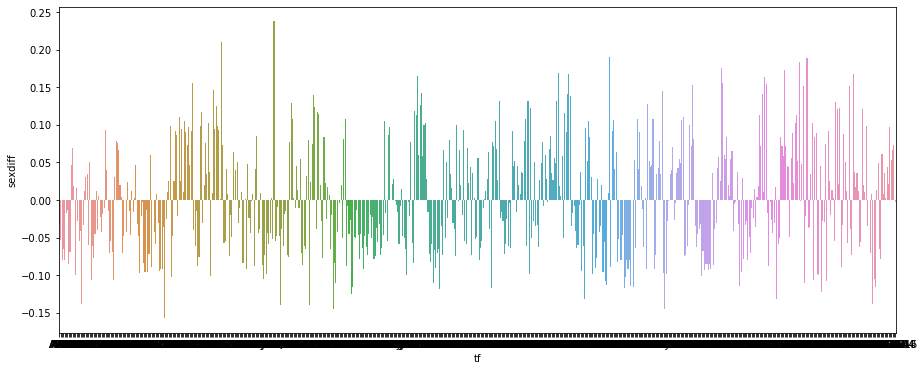

In [ ]:
ff=pd.read_csv('drive/My Drive/TF_zscore_O.txt',sep='\t',header=0)
fff=pd.read_csv('drive/My Drive/gene_zscore_O.txt',sep='\t',header=0)
mm=pd.read_csv('drive/My Drive/TF_zscore_Y.txt',sep='\t',header=0)
mmm=pd.read_csv('drive/My Drive/gene_zscore_Y.txt',sep='\t',header=0)
sex_tf_diff=ff.merge(mm,on='tf')
# sex_gene_diff=fff.merge(mmm,on='gene')
 
plt.figure(figsize=(15,6))
sex_tf_diff['sexdiff']=sex_tf_diff['diff_x']-sex_tf_diff['diff_y']
# sex_tf_diff=sex_tf_diff.sort_values(by=['sexdiff'])
sex_tf_diff=sex_tf_diff.sort_values(by=['tf'])
sns.barplot(data=sex_tf_diff,y='sexdiff',x='tf')

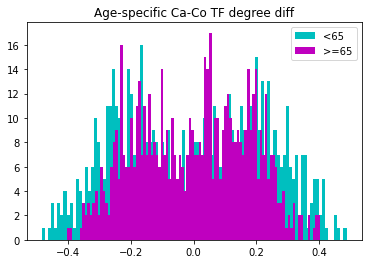

In [ ]:
a=plt.hist(sex_tf_diff['diff_x'],bins=100,label='<65',color='c')
b=plt.hist(sex_tf_diff['diff_y'],bins=100,label='>=65',color='m')
plt.title('Age-specific Ca-Co TF degree diff')
plt.legend(loc="best")

In [ ]:
# [sex_tf_diff[np.abs(sex_tf_diff['diff_x'])>.4].tf,
sex_tf_diff#[np.abs(sex_tf_diff['diff_y'])>.4].tf]

,tf,force_x_x,force_y_x,diff_x,force_x_y,force_y_y,diff_y,sexdiff
106,AHR,-0.063462,0.191176,-0.254638,-0.096085,0.126451,-0.222536,-0.032102
131,AIRE,0.215897,0.446774,-0.230877,0.161294,0.338623,-0.177329,-0.053548
37,ALX1,-0.111129,0.225843,-0.336972,-0.128569,0.128128,-0.256697,-0.080275
49,ALX3,-0.188581,0.125785,-0.314366,-0.213315,0.035178,-0.248493,-0.065873
55,ALX4,-0.222160,0.087562,-0.309722,-0.244430,-0.014843,-0.229587,-0.080135
...,...,...,...,...,...,...,...,...
485,ZNF75A,0.568160,0.366642,0.201519,0.570813,0.466667,0.104146,0.097373
382,ZNF784,-0.494082,-0.588898,0.094815,-0.450194,-0.491682,0.041488,0.053327
478,ZSCAN10,-0.124708,-0.323852,0.199145,-0.168546,-0.300653,0.132108,0.067037
349,ZSCAN16,0.013386,-0.038920,0.052305,-0.092833,-0.071734,-0.021099,0.073404
